In [2]:
!pip install sentencepiece

In [3]:
!pip install seaborn

In [210]:
# importing libraries
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras


import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [211]:
# Read the dataset
import pandas as pd
df = pd.read_csv('DM_Final/winemag-data-130k-v2.csv')

df.head()


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [212]:
# Clean up the data
df = df[['country','description','price','province','title','variety']]
df.head()

,country,description,price,province,title,variety
0,Italy,"Aromas include tropical fruit, broom, brimston...",NaN,Sicily & Sardinia,Nicosia 2013 Vulkà Bianco (Etna),White Blend
1,Portugal,"This is ripe and fruity, a wine that is smooth...",15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red
2,US,"Tart and snappy, the flavors of lime flesh and...",14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris
3,US,"Pineapple rind, lemon pith and orange blossom ...",13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling
4,US,"Much like the regular bottling from 2012, this...",65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir


In [213]:
# Remove points with NaN entries
df = df.dropna()
df

,country,description,price,province,title,variety
1,Portugal,"This is ripe and fruity, a wine that is smooth...",15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red
2,US,"Tart and snappy, the flavors of lime flesh and...",14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris
3,US,"Pineapple rind, lemon pith and orange blossom ...",13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling
4,US,"Much like the regular bottling from 2012, this...",65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir
5,Spain,Blackberry and raspberry aromas show a typical...,15.0,Northern Spain,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot
...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,28.0,Mosel,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling
129967,US,Citation is given as much as a decade of bottl...,75.0,Oregon,Citation 2004 Pinot Noir (Oregon),Pinot Noir
129968,France,Well-drained gravel soil gives this wine its c...,30.0,Alsace,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer
129969,France,"A dry style of Pinot Gris, this is crisp with ...",32.0,Alsace,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris


In [8]:
# Get top 5 most popular varieties 
df_variety = df.variety.value_counts()
df_variety.head()

Pinot Noir                  12785
Chardonnay                  11077
Cabernet Sauvignon           9384
Red Blend                    8466
Bordeaux-style Red Blend     5340
Name: variety, dtype: int64

In [9]:
# Get top 5 most popular countires 
df_country = df.country.value_counts()
df_country.head()

US          54265
France      17776
Italy       16914
Spain        6573
Portugal     4875
Name: country, dtype: int64

Text(0.5, 1, 'Country Distribution')

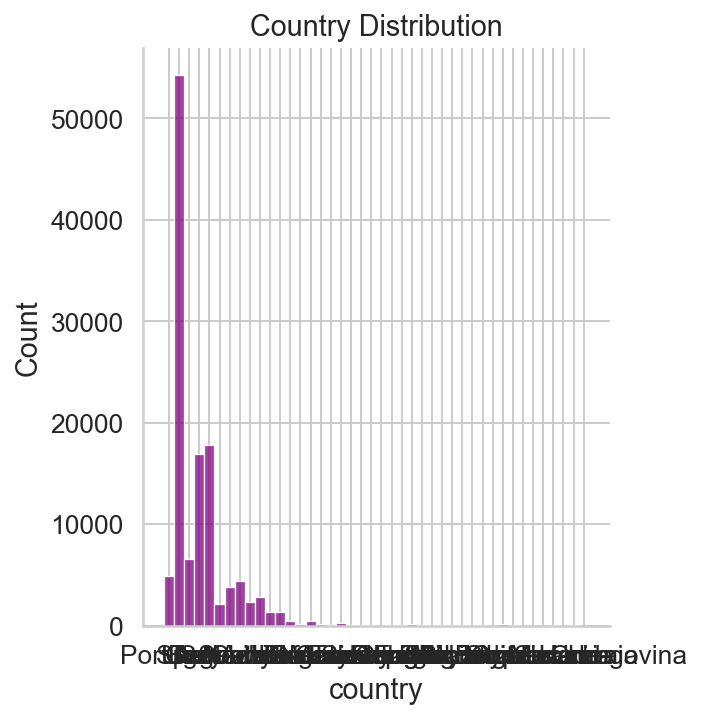

In [10]:
# Country distribution for the entire dataset
# This is not readable -- needs to be fixed
chart = sns.displot(x=df['country'], color = 'purple')
#plt.xlim(0,75)
plt.title("Country Distribution")

In [11]:
# Get top 5 most popular regions 
df_province = df.province.value_counts()
df_province.head()

California    36104
Washington     8583
Oregon         5359
Tuscany        5128
Bordeaux       4002
Name: province, dtype: int64

In [12]:
# Get top 20 most popular price points 
df_price = df.price.value_counts()
df_price.head(20)

20.0    6938
15.0    6066
25.0    5796
30.0    4946
18.0    4881
12.0    3932
40.0    3871
35.0    3801
13.0    3548
16.0    3545
10.0    3439
22.0    3353
50.0    3332
14.0    3214
45.0    3135
17.0    3049
28.0    2938
24.0    2824
19.0    2813
60.0    2277
Name: price, dtype: int64

In [13]:
# Helpful statitics to get a general understanding of price distribution
df['price'].describe()

count    120915.000000
mean         35.368796
std          41.031188
min           4.000000
25%          17.000000
50%          25.000000
75%          42.000000
max        3300.000000
Name: price, dtype: float64

Text(0.5, 1, 'Price Distribution')

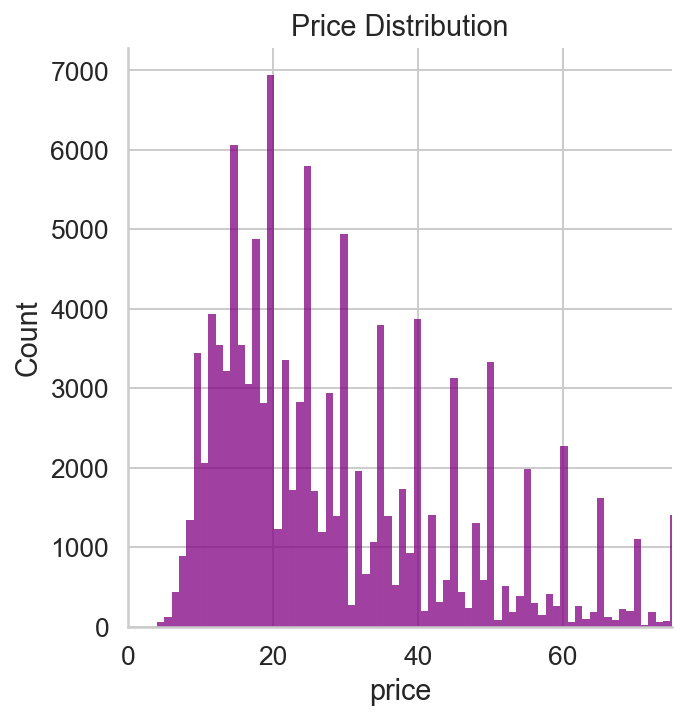

In [14]:
# Price distribution for the entire dataset
chart = sns.displot(x=df['price'], color = 'purple')
plt.xlim(0,75)
plt.title("Price Distribution")

/Users/Nina/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


There are : 0.5640325848736716 % wines more expensive then 200 USD


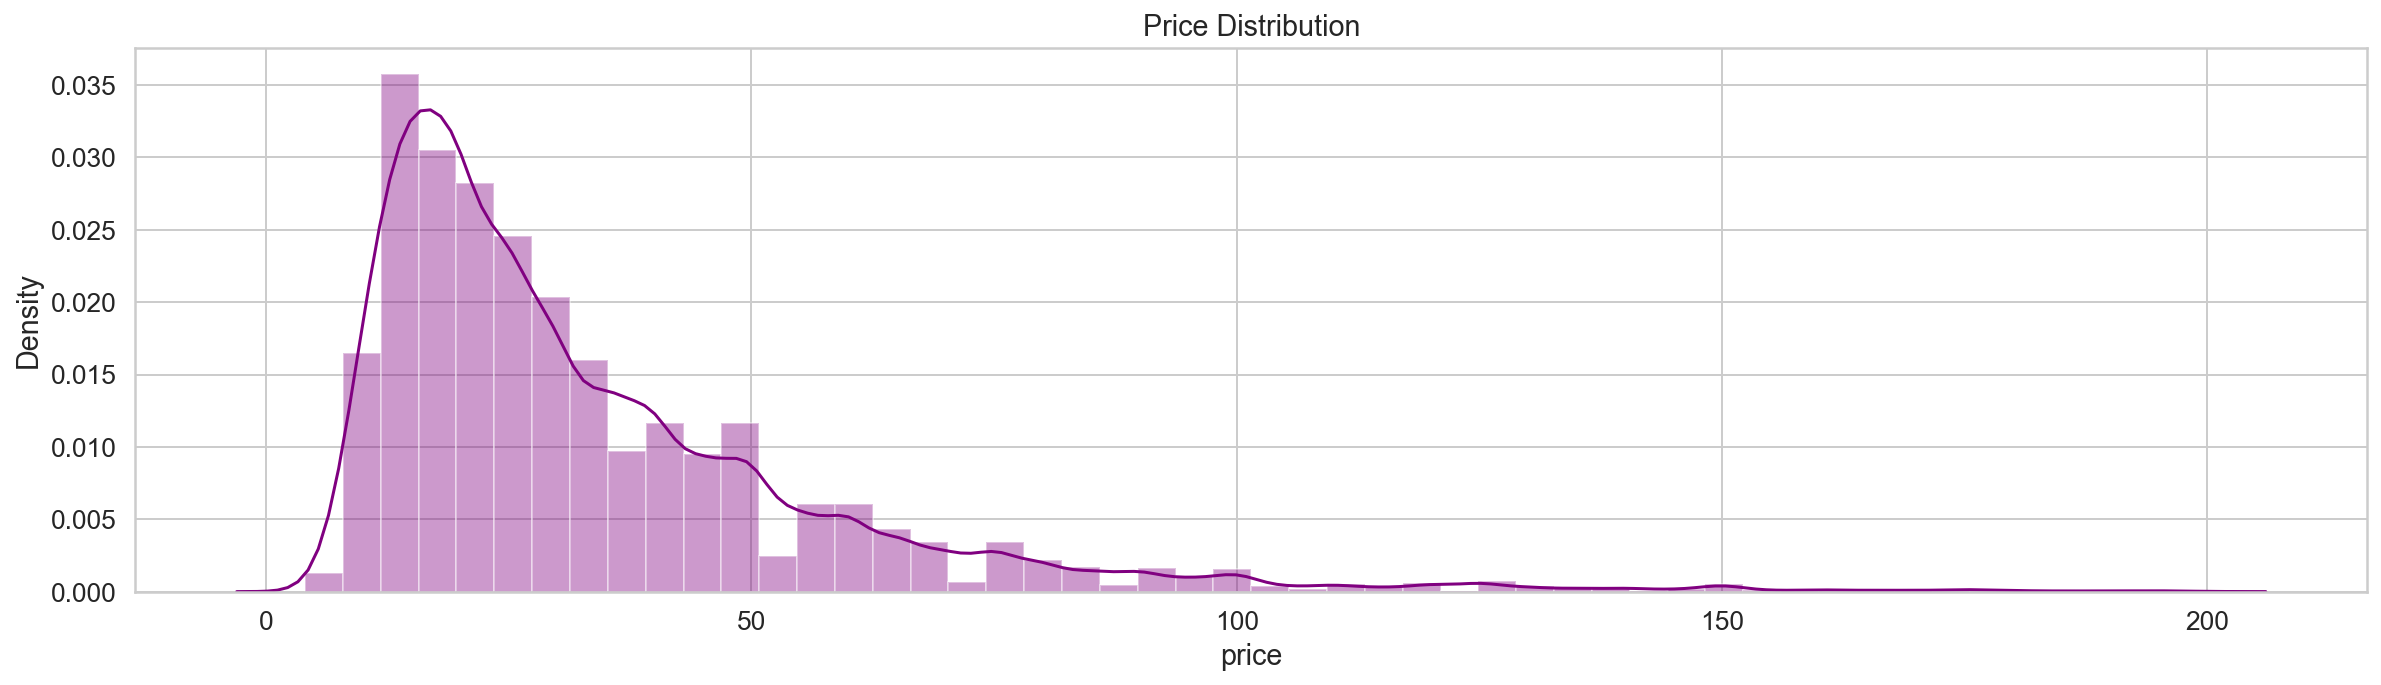

In [15]:
plt.figure(figsize=(20,5))
plt.title("Price Distribution")
chart = sns.distplot(df[df["price"]<200]['price'], color='purple')

percent=df[df['price']>200].shape[0]/df.shape[0]*100
print("There are :", percent, "% wines more expensive then 200 USD")

In [16]:
# Find duplicates
print("Total number of examples: ", df.shape[0])
print("Number of examples with the same title and description: ", df[df.duplicated(['description','title'])].shape[0])

Total number of examples:  120915
Number of examples with the same title and description:  9378


In [214]:
# Remove datapoints with the same title and description
df=df.drop_duplicates(['description','title'])
df=df.reset_index(drop=True)

In [18]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [19]:
!pip install wordcloud

In [215]:
# NLP
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import string

from wordcloud import WordCloud, STOPWORDS
import re

from nltk.tokenize import RegexpTokenizer

In [216]:
# Text preprocessing

# Lowercasing
df['description']= df['description'].str.lower()
df['description']= df['description'].apply(lambda elem: re.sub('[^a-zA-Z]',' ', elem))  
df['description']

0         this is ripe and fruity  a wine that is smooth...
1         tart and snappy  the flavors of lime flesh and...
2         pineapple rind  lemon pith and orange blossom ...
3         much like the regular bottling from       this...
4         blackberry and raspberry aromas show a typical...
                                ...                        
111532    notes of honeysuckle and cantaloupe sweeten th...
111533    citation is given as much as a decade of bottl...
111534    well drained gravel soil gives this wine its c...
111535    a dry style of pinot gris  this is crisp with ...
111536    big  rich and off dry  this is powered by inte...
Name: description, Length: 111537, dtype: object

In [217]:
# Tokenize sentences to list of words since we can't analyze whole sentences
tokenizer = RegexpTokenizer(r'\w+')
words_descriptions = df['description'].apply(tokenizer.tokenize)
words_descriptions.head()

0    [this, is, ripe, and, fruity, a, wine, that, i...
1    [tart, and, snappy, the, flavors, of, lime, fl...
2    [pineapple, rind, lemon, pith, and, orange, bl...
3    [much, like, the, regular, bottling, from, thi...
4    [blackberry, and, raspberry, aromas, show, a, ...
Name: description, dtype: object

In [218]:
# Create a vocabulary
all_words = [word for tokens in words_descriptions for word in tokens]
df['description_lengths']= [len(tokens) for tokens in words_descriptions]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))

4622533 words total, with a vocabulary size of 29476


In [219]:
# Check most commonly used words
from collections import Counter
count_all_words = Counter(all_words)
count_all_words.most_common(100)

[('and', 302742),
 ('the', 190741),
 ('a', 154743),
 ('of', 149729),
 ('with', 104056),
 ('this', 97956),
 ('is', 81880),
 ('it', 74605),
 ('wine', 66673),
 ('flavors', 55583),
 ('in', 55146),
 ('to', 48436),
 ('s', 46888),
 ('fruit', 42615),
 ('on', 40202),
 ('that', 34349),
 ('aromas', 34255),
 ('palate', 33538),
 ('finish', 30946),
 ('acidity', 28921),
 ('from', 27765),
 ('but', 27551),
 ('tannins', 25870),
 ('drink', 25687),
 ('cherry', 25557),
 ('black', 24914),
 ('are', 22553),
 ('ripe', 22535),
 ('has', 20389),
 ('for', 19011),
 ('red', 18588),
 ('by', 17474),
 ('notes', 16612),
 ('spice', 16206),
 ('oak', 16018),
 ('an', 15664),
 ('as', 15501),
 ('its', 15191),
 ('dry', 15037),
 ('now', 14952),
 ('nose', 14949),
 ('rich', 14686),
 ('berry', 14525),
 ('fresh', 14494),
 ('full', 13624),
 ('plum', 13066),
 ('sweet', 11813),
 ('apple', 11635),
 ('blend', 11570),
 ('soft', 11557),
 ('well', 11314),
 ('blackberry', 11310),
 ('white', 11003),
 ('fruits', 10842),
 ('light', 10835),
 ('

In [25]:
# Download a list of commonly used stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/Nina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [220]:
# Stopword removal + lemmatization
stopword_list = stopwords.words('english')
ps = PorterStemmer()
words_descriptions = words_descriptions.apply(lambda elem: [word for word in elem if not word in stopword_list])
words_descriptions = words_descriptions.apply(lambda elem: [ps.stem(word) for word in elem])
df['processed_description'] = words_descriptions.apply(lambda elem: ' '.join(elem))

In [221]:
all_words = [word for tokens in words_descriptions for word in tokens]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
count_all_words = Counter(all_words)
count_all_words.most_common(100)

# Deleted around 8k words

2820894 words total, with a vocabulary size of 21063


[('wine', 69089),
 ('flavor', 62638),
 ('fruit', 53822),
 ('finish', 35823),
 ('aroma', 35526),
 ('palat', 33649),
 ('acid', 33313),
 ('cherri', 29476),
 ('drink', 28900),
 ('tannin', 27704),
 ('black', 24941),
 ('ripe', 24034),
 ('dri', 22833),
 ('note', 21882),
 ('spice', 20035),
 ('red', 18806),
 ('rich', 18377),
 ('fresh', 18082),
 ('berri', 16563),
 ('oak', 16553),
 ('show', 15938),
 ('nose', 14963),
 ('plum', 14240),
 ('sweet', 13919),
 ('full', 13724),
 ('offer', 13692),
 ('blackberri', 13386),
 ('textur', 13368),
 ('blend', 13270),
 ('appl', 13137),
 ('bodi', 12997),
 ('balanc', 12996),
 ('soft', 12039),
 ('age', 11715),
 ('crisp', 11398),
 ('well', 11325),
 ('light', 11144),
 ('white', 11143),
 ('dark', 10648),
 ('structur', 10641),
 ('citru', 10099),
 ('raspberri', 9906),
 ('cabernet', 9853),
 ('vanilla', 9822),
 ('hint', 9748),
 ('herb', 9713),
 ('miner', 9666),
 ('fruiti', 9651),
 ('bright', 9372),
 ('give', 9220),
 ('pepper', 9125),
 ('touch', 8878),
 ('year', 8657),
 ('gr

In [222]:
# Check for correctness by looking at 2 random rows of processed dataset
df[['description','processed_description','variety']].sample(2)

,description,processed_description,variety
97613,there s a ton of cabernet flavor here the cal...,ton cabernet flavor california sunshin warm ap...,Cabernet Sauvignon
23414,mango aromas bring out the tropical character ...,mango aroma bring tropic charact superrip wine...,Chardonnay


<FreqDist with 21063 samples and 2820894 outcomes>


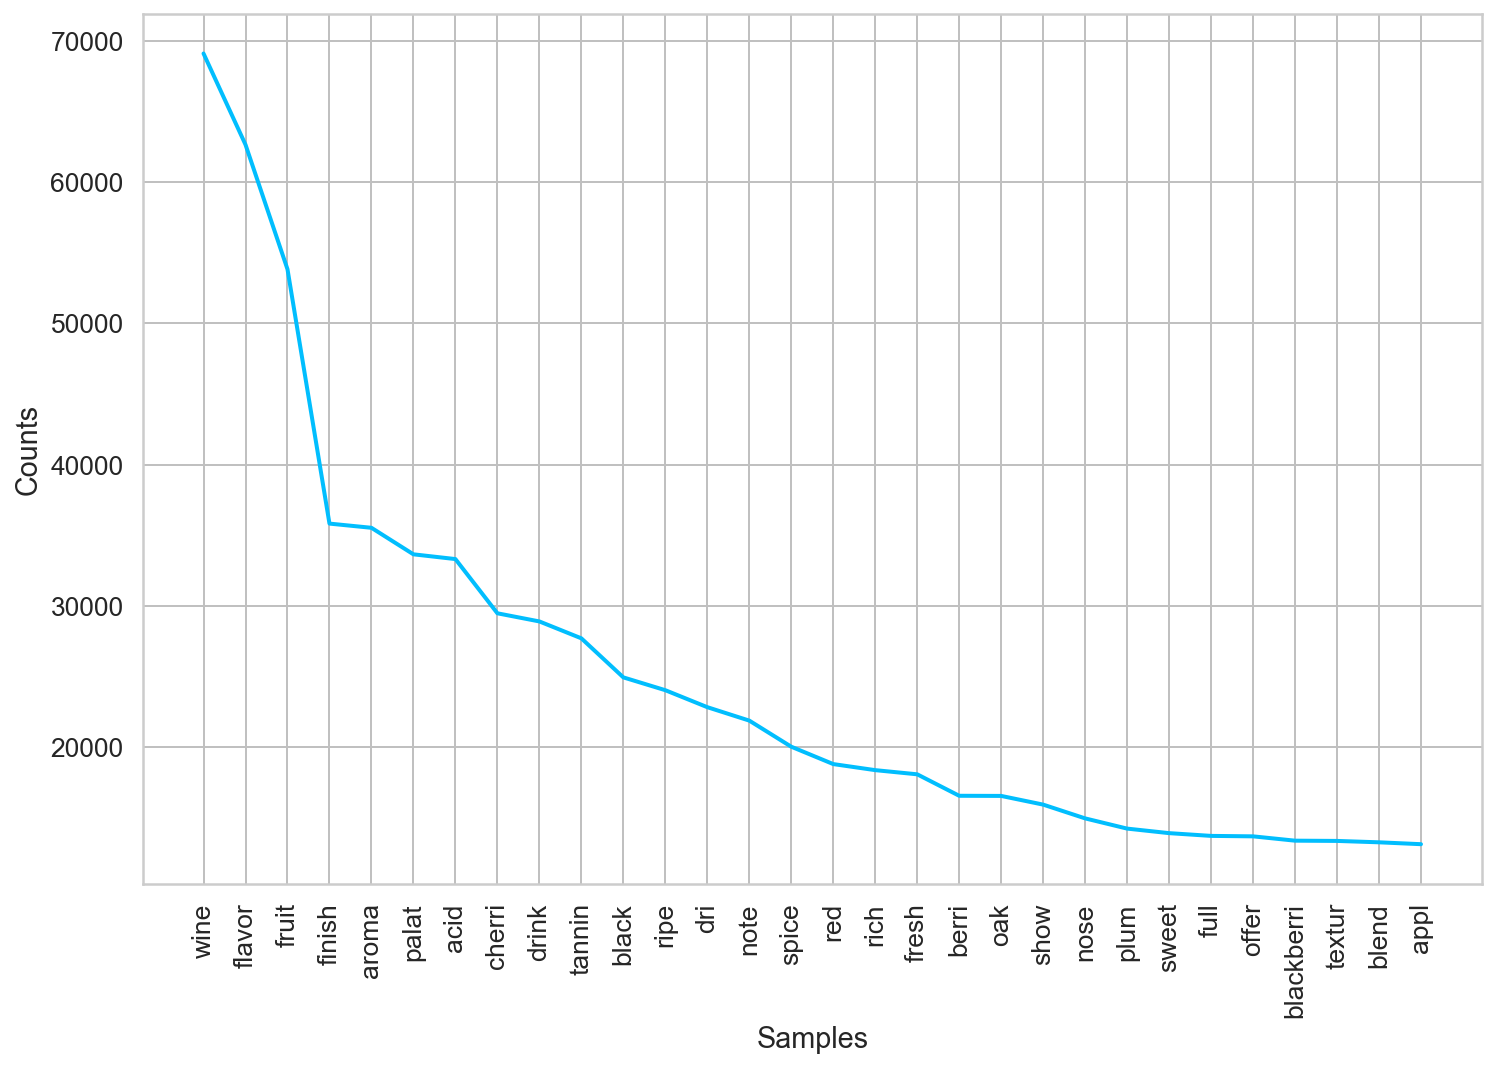

In [29]:
from nltk.probability import FreqDist
fdist = FreqDist(all_words)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()

In [30]:
df.head()

,country,description,price,province,title,variety,description_lengths,processed_description
0,Portugal,this is ripe and fruity a wine that is smooth...,15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,38,ripe fruiti wine smooth still structur firm ta...
1,US,tart and snappy the flavors of lime flesh and...,14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,29,tart snappi flavor lime flesh rind domin green...
2,US,pineapple rind lemon pith and orange blossom ...,13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,34,pineappl rind lemon pith orang blossom start a...
3,US,much like the regular bottling from this...,65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,41,much like regular bottl come across rather rou...
4,Spain,blackberry and raspberry aromas show a typical...,15.0,Northern Spain,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,42,blackberri raspberri aroma show typic navarran...


In [34]:
# # Turn processed text into an array
# from sklearn.feature_extraction.text import CountVectorizer
# vectorize = CountVectorizer(tokenizer=lambda doc: doc)
# X_train = vectorize.fit_transform(train_df['processed_description'])

# X_test = vectorize.transform(test_df['processed_description'])

# train_df = pd.DataFrame(X_train)
# test_df = pd.DataFrame(X_test)

In [35]:
train_df.head()

,0
0,"(0, 12)\t14\n (0, 1)\t29\n (0, 0)\t38\n (..."
1,"(0, 12)\t6\n (0, 1)\t14\n (0, 0)\t25\n (0..."
2,"(0, 12)\t12\n (0, 1)\t20\n (0, 0)\t34\n (..."
3,"(0, 12)\t6\n (0, 1)\t8\n (0, 0)\t20\n (0,..."
4,"(0, 12)\t11\n (0, 1)\t13\n (0, 0)\t35\n (..."


In [36]:
test_df.head()

,0
0,"(0, 0)\t24\n (0, 1)\t13\n (0, 2)\t2\n (0,..."
1,"(0, 0)\t16\n (0, 1)\t9\n (0, 2)\t2\n (0, ..."
2,"(0, 0)\t29\n (0, 1)\t11\n (0, 2)\t2\n (0,..."
3,"(0, 0)\t19\n (0, 1)\t9\n (0, 2)\t2\n (0, ..."
4,"(0, 0)\t17\n (0, 1)\t7\n (0, 2)\t4\n (0, ..."


In [37]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/Nina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

,country,variety,price
1,Portugal,Portuguese Red,15.0
2,US,Pinot Gris,14.0
3,US,Riesling,13.0
4,US,Pinot Noir,65.0
5,Spain,Tempranillo-Merlot,15.0
...,...,...,...
129966,Germany,Riesling,28.0
129967,US,Pinot Noir,75.0
129968,France,Gewürztraminer,30.0
129969,France,Pinot Gris,32.0


In [255]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import train_test_split

# Splitting the dataset
from sklearn.model_selection import train_test_split

wine_description_I = pd.DataFrame()
wine_description_I['processed_description'] = ['light earthy red wine go well pasta']

X = df['processed_description']
Y1 = df['variety']

X_train, X_test, y_train, y_test = train_test_split(X, Y1, test_size = 0.2, random_state = 42)

train_df = pd.DataFrame(X_train)
test_df = pd.DataFrame(X_test)

from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)
wine_description_I_counts = count_vect.transform(wine_description_I)


from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
wine_description_I_tfidf = tfidf_transformer.transform(wine_description_I_counts)

from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, y_train)
import numpy as np
predicted = clf.predict(X_test_tfidf)
accuracy = np.mean(predicted == y_test)
print("Accuracy of NLP model: ", accuracy)

pred_I = clf.predict(wine_description_I_tfidf)
print("Light, earthy red wine that goes well with pasta", pred_I)

Accuracy of NLP model:  0.37018110095033174
Light, earthy red wine that goes well with pasta ['Pinot Noir']


<1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [186]:
# Multinomial Logistic Regression Pt.II: variety + price -> country
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

df = pd.read_csv('DM_Final/winemag-data-130k-v2.csv')
df = df[['country','variety','price']]
df = df.dropna()

X = df[['price', 'variety']]
Y = df['country']


# Params for the regression variety, price --> country
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, Y, test_size = 0.2, random_state = 42)

clf2 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter = 1500)

# This converts variety string to a numeric value in order to run the regression
def convert(data):
    number = preprocessing.LabelEncoder()
    data['variety'] = number.fit_transform(data['variety'])
    data['variety']=data['variety'].fillna(-999)
    return data

X_train2=convert(train_df2)
X_test2=convert(test_df2)


# Fit the model
clf2.fit(X_train2, y_train2)
score = clf2.score(X_test2, y_test2)
print("Accuracy for predicting a country based on price and variety: ",score)



Accuracy for predicting a country based on price and variety:  0.44940660794773185


/Users/Nina/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [204]:
# Predict a country based on price and variety
wine_test_I = pd.DataFrame()
wine_test_II = pd.DataFrame()
wine_test_III = pd.DataFrame()

# Create some feature values for this single row
wine_test_I['price'] = [10]
wine_test_I['variety'] = ['Chardonnay']
wine_test_II['price'] = [50]
wine_test_II['variety'] = ['Pinot Noir']
wine_test_III['price'] = [500]
wine_test_III['variety'] = ['Cabernet Sauvignon']

def convert(data):
    number = preprocessing.LabelEncoder()
    data['variety'] = number.fit_transform(data['variety'])
    data['variety']=data['variety'].fillna(-999)
    return data

wine_test_I=convert(wine_test_I)
wine_test_II=convert(wine_test_II)
wine_test_III=convert(wine_test_III)

wine_test_I = clf2.predict(wine_test_I)
print("$5 Chardonnay is from ", wine_test_I)
wine_test_II = clf2.predict(wine_test_II)
print("$30 Pinot Noir is from ", wine_test_II)
wine_test_III = clf2.predict(wine_test_III)
print("$500 Cabernet Sauvignon is from", wine_test_III)

$5 Chardonnay is from  ['US']
$30 Pinot Noir is from  ['US']
$500 Cabernet Sauvignon is from ['France']


In [175]:
# Predict country based on price
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

df = pd.read_csv('DM_Final/winemag-data-130k-v2.csv')
df = df[['country','price']]
df = df.dropna()
X = df[['price']]
Y = df['country']

# Params for the regression price --> country
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, Y, test_size = 0.2, random_state = 42)

from sklearn.preprocessing import StandardScaler
std = StandardScaler()
price = np.append(X_train3[['price']].values,X_test3[['price']].values)
std.fit(price.reshape(-1, 1))

X_train3['price']=std.transform(X_train3[['price']])
X_test3['price']=std.transform(X_test3[['price']])

clf3 = LogisticRegression(solver='lbfgs', max_iter = 1500)

# Fit the model
clf3.fit(X_train3, y_train3)
score = clf3.score(X_test3, y_test3)
print("Accuracy for predicting a country based on price: ",score)



/Users/Nina/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Nina/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy for predicting a country based on price:  0.44955342375124047


In [197]:
# Predict a country based on price
wine_test_low = pd.DataFrame()
wine_test_medium = pd.DataFrame()
wine_test_high = pd.DataFrame()

# Create some feature values for this single row
wine_test_low['price'] = [5]
wine_test_medium['price'] = [30]
wine_test_high['price'] = [500]

wine_test_low = clf3.predict(wine_test_low)
print("Low price wine is from ", wine_test_low)
wine_test_medium = clf3.predict(wine_test_medium)
print("Medium price wine is from ", wine_test_medium)
wine_test_high = clf3.predict(wine_test_high)
print("High price wine is from ", wine_test_high)

Low price wine is from  ['US']
Medium price wine is from  ['France']
High price wine is from  ['Switzerland']


In [173]:
# Logistic regression
from sklearn.linear_model import LogisticRegression
# import joblib

model = LogisticRegression(max_iter=150).fit(X_train, y_train)
    
def simple_logistic_classify(X_train, y_train, X_test, y_test, _C=1.0):
    # Initialize and fit the model
    y_pred=model.predict(X_test)
    score = model.score(X_test, y_test)
    print(y_pred)
    print('Test Score: ', score)

#     # save the model 
#     joblib_file = 'wine_model.sav'
#     joblib.dump(model, joblib_file)
#     return model

# Cleas input string
def clean_text(sentence):
    '''Text Preprocessing '''
    
    # Convert words to lower case
    sentence = sentence.lower()
    
    # Format words and remove unwanted characters
    sentence = re.sub(r'https?:\/\/.*[\r\n]*', '', sentence, flags=re.MULTILINE)
    sentence = re.sub(r'\<a href', ' ', sentence)
    sentence = re.sub(r'&amp;', '', sentence) 
    sentence = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', sentence)
    sentence = re.sub(r'<br />', ' ', sentence)
    sentence = re.sub(r'\'', ' ', sentence)
    
    # remove stopwords
    sentence = sentence.split()
    stops = set(stopwords.words("english"))
    sentence = [w for w in sentence if not w in stops]
    sentence = " ".join(sentence)

    # Tokenize each word
    sentence =  nltk.WordPunctTokenizer().tokenize(sentence)

#     # Lemmatize each token
#     lemm = nltk.stem.WordNetLemmatizer()
#     sentence = list(map(lambda word:list(map(lemm.lemmatize, word)), sentence))
    
    return sentence

# Trying it out
def recommend_wine(sentence):
    # Preprocess the input
    sentence = clean_text(sentence)
    
    # Turn processed text into an array
    vectorize = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[3,3], lowercase=False)
    array_text = vectorize.fit_transform(sentence)
    Xarray_text = array_text.todense()

#     wine_model = joblib.load(joblib_file)
    prediction = model.predict(array_text)
    print(predict)
#     for text, label in zip(sentence, prediction):
#         print("text:", text, "\nintent:", classes[label])
#         print()

ValueError: could not convert string to float: 'la playa good job captur colchagua warmth translat healthi wine like light oak aroma manifest butter dill coconut berri fruit cola also part aromat packag bit lean snappi mouth strawberri raspberri flavor mix carob cream tight typic solid carmen'

In [93]:
simple_logistic_classify(X_train, y_train, X_test, y_test, _C=1.0)

/Users/Nina/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


['Cabernet Sauvignon' 'Sauvignon Blanc' 'Syrah' ... 'Syrah' 'Garnacha'
 'Pinot Noir']
Test Score:  0.5652232383001614


LogisticRegression()